In [1]:
# Jovian Commit Essentials
# Please retain and execute eish cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('04-feedforward-nn')
jovian.set_colab_id('1JpvsG0NPeHhf9mD21gwnYV_KeO4mBJrB')

In [2]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [3]:
import torch 
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

#use a white backgroud for matplotlib figures
matplotlib.rcParams ['figure.facecolor'] ='#ffffff'


In [4]:
dataset= MNIST (root='data/', download =True, transform= ToTensor())


image.shape torch.Size([1, 28, 28])
Label: 5


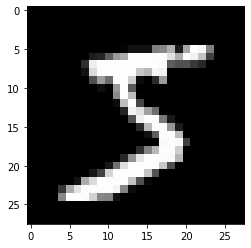

In [5]:
image, label = dataset[0]
print ('image.shape', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


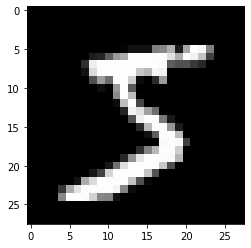

In [6]:
image, label = dataset[0]
print ('image.shape:', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

In [7]:
val_size= 10000
train_size= len(dataset) - val_size
train_ds, val_ds = random_split (dataset, [train_size, val_size])
len(train_ds) , len (val_ds)

(50000, 10000)

In [8]:
batch_size= 128

In [9]:
train_loader = DataLoader ( train_ds, batch_size, shuffle = True,
num_workers=4, pin_memory = True)
val_loader = DataLoader ( val_ds, batch_size*2, num_workers= 4, 
                         pin_memory = True)


images.shape: torch.Size([128, 1, 28, 28])


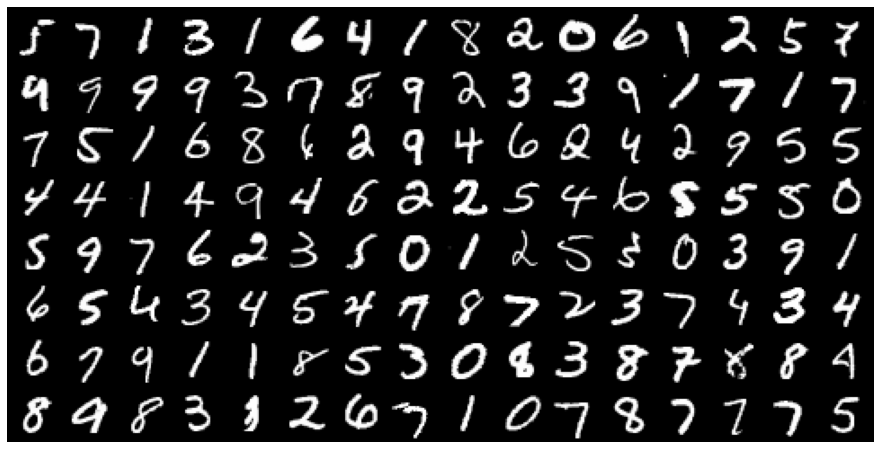

In [10]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
    break

images.shape: torch.Size([1, 28, 28])
Lable: 5


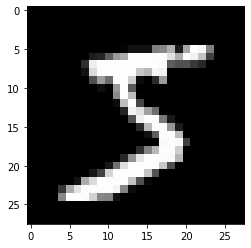

In [11]:
image, label = dataset[0]
print ('images.shape:', image.shape)
plt.imshow (image.permute(1,2,0), cmap= 'gray')
print('Lable:', label)

In [12]:
for images, labels in train_loader:
    print ('images.shape:', images.shape)
    inputs= images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [13]:
input_size= inputs.shape[-1]
hidden_size = 32

In [14]:
layer1= nn.Linear (input_size, hidden_size)


In [15]:
inputs.shape

torch.Size([128, 784])

In [16]:
layer1_outputs = layer1 (inputs)
print ('layer1_outputs.shape:',layer1_outputs.shape )

layer1_outputs.shape: torch.Size([128, 32])


In [17]:
layer1_outputs_direct = inputs @ layer1.weight.t()
layer1_outputs_direct.shape

torch.Size([128, 32])

In [18]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

False

In [19]:
F.relu(torch.tensor([[1,-1,0],[-0.1,.2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [20]:
relu_outputs= F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7303373217582703
min(relu_outputs): 0.0


In [21]:
output_size = 10
layer2= nn.Linear (hidden_size, output_size)

In [22]:
layer2_outputs = layer2 (relu_outputs)
print(layer2_outputs.shape)


torch.Size([128, 10])


In [23]:
inputs.shape

torch.Size([128, 784])

In [24]:
F.cross_entropy (layer2_outputs, labels)

tensor(2.2989, grad_fn=<NllLossBackward0>)

In [25]:
# Expanded version of layer2 (F.relu(layer1(inputs)))
outputs = (F.relu(inputs@ layer1.weight.t() + layer1.bias))@ layer2.weight.t() + layer2.bias

In [26]:
torch.allclose (outputs, layer2_outputs, 1e-3)

True

In [27]:
outputs2= (inputs@ layer1.weight.t() + layer1.bias)@layer2.weight.t()+ layer2.bias

In [28]:
combined_layer= nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight@ layer1.weight
combined_layer.bias.data= layer1.bias@layer2.weight.t() + layer2.bias

In [29]:
outputs3= inputs @combined_layer.weight.t()+ combined_layer.bias

In [30]:
torch.allclose (outputs2, outputs3, 1e-3)

True

# Model

In [31]:
def accuracy(outputs, labels):
    _,preds= torch.max(outputs, dim=1)
    return torch. tensor(torch.sum(preds == labels).item()/ len(preds))


In [32]:
class MnistModel (nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1= nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2= nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view (xb.size(0),-1)
        # Get intermidate outputs using hideen layer
        out = self.linear1(xb)
        # Apply Activation Function
        out = F.relu (out)
        # Get prediction using output layer
        out = self. linear2 (out)
        return out
    
    def training_step (self, batch):
        images, labels = batch
        out = self (images)                 # Generate predictions
        loss= F.cross_entropy (out, labels) # Calculate Loss
        return loss
    
    def validation_step (self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc= accuracy (out, labels)
        return {'val_loss' : loss, 'val_acc': acc}
    
    def validation_epoch_end (self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack (batch_losses).mean() # combine loss
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc= torch.stack(batch_acc).mean()  # Combine Accuracies
        return { 'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end (self,epoch, result):
        print ("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}" .format(epoch, result['val_loss'], result['val_acc']))

In [33]:
input_size = 784
hidden_size = 32
num_classes = 10

In [34]:
model = MnistModel ( input_size, hidden_size =32, out_size = num_classes)

In [35]:
for t in model.parameters():
    print (t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [36]:
for images , labels in train_loader:
    outputs = model (images)
    loss= F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break
    
print ('outputs.shape:', outputs.shape)
print('Sample outputs :\n', outputs[:2].data )

Loss: 2.301884651184082
outputs.shape: torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1044, -0.0812, -0.0770, -0.2632,  0.1885, -0.0087,  0.0398,  0.0138,
          0.0955,  0.1685],
        [ 0.1392, -0.2195, -0.0608, -0.1163,  0.1490,  0.0584,  0.0566,  0.0641,
          0.1567,  0.1580]])


In [37]:
print(torch.backends.mps.is_available())

True


In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if (torch.backends.mps.is_available()):
        return torch.device('mps')
    else:
        return torch.device('cpu')

In [39]:
device = get_default_device()
device

device(type='mps')

In [40]:
def to_device (data, device):
    """Move tensor(s) to chosen device"""
    if isinstance (data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

In [41]:
for images, labels in train_loader:
    print (images.shape)
    images= to_device(images,device)
    print (images.device)
    break

torch.Size([128, 1, 28, 28])
mps:0


In [42]:
class DeviceDataLoader ():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl= dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [43]:
def some_numbers():
    yield 10
    yield 20
    yield 30
for value in some_numbers():
    print (value)

10
20
30


In [44]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [45]:
for xb, yb in val_loader:
    print ('xb.device:', xb.device)
    print ('yb:', yb)
    break

xb.device: mps:0
yb: tensor([6, 9, 2, 8, 1, 2, 1, 3, 3, 2, 5, 4, 7, 2, 6, 1, 1, 4, 9, 0, 0, 9, 4, 0,
        0, 3, 3, 4, 4, 2, 1, 8, 3, 1, 7, 3, 8, 1, 4, 2, 5, 8, 0, 0, 2, 9, 1, 4,
        9, 6, 0, 3, 8, 1, 3, 8, 2, 9, 8, 3, 0, 5, 0, 7, 3, 5, 7, 9, 3, 2, 9, 6,
        8, 1, 3, 8, 0, 5, 3, 4, 8, 7, 7, 9, 5, 8, 3, 1, 7, 6, 7, 6, 6, 2, 9, 7,
        6, 6, 5, 3, 7, 3, 3, 3, 2, 6, 0, 8, 9, 2, 3, 6, 5, 8, 7, 0, 6, 1, 8, 3,
        3, 2, 7, 9, 1, 6, 5, 7, 3, 2, 5, 8, 4, 0, 6, 9, 1, 2, 7, 9, 4, 9, 3, 4,
        7, 2, 0, 8, 5, 2, 2, 4, 4, 5, 9, 8, 5, 6, 4, 8, 2, 4, 7, 4, 4, 8, 4, 7,
        0, 7, 0, 0, 9, 9, 6, 9, 5, 5, 7, 7, 4, 3, 0, 1, 1, 1, 9, 0, 7, 5, 2, 0,
        0, 8, 7, 1, 6, 4, 1, 7, 4, 1, 3, 9, 9, 9, 4, 2, 6, 7, 6, 4, 1, 4, 3, 4,
        7, 2, 6, 0, 0, 6, 0, 5, 1, 2, 6, 9, 1, 6, 4, 8, 0, 3, 8, 4, 0, 2, 5, 8,
        0, 6, 4, 1, 3, 1, 6, 2, 3, 1, 1, 9, 8, 9, 7, 5], device='mps:0')


# Training Model

In [70]:
def evaluate (model , val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit (epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    """Train the Model using gradien descent"""
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range (epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation Phase
        result = evaluate (model, val_loader)
        model.epoch_end(epoch, result)
        history.append (result)
    return history


In [71]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size= num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [72]:
history= [evaluate(model, val_loader)]
print (history)

[{'val_loss': 2.3267605304718018, 'val_acc': 0.06621094048023224}]


In [73]:
history+=(fit (5,0.5, model, train_loader, val_loader)) 

Epoch [0], val_loss: 0.2343, val_acc: 0.9292
Epoch [1], val_loss: 0.1739, val_acc: 0.9480
Epoch [2], val_loss: 0.1555, val_acc: 0.9535
Epoch [3], val_loss: 0.1616, val_acc: 0.9537
Epoch [4], val_loss: 0.1435, val_acc: 0.9563


In [74]:
print(len(history))

6


In [75]:
history += fit (5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1189, val_acc: 0.9643
Epoch [1], val_loss: 0.1180, val_acc: 0.9642
Epoch [2], val_loss: 0.1171, val_acc: 0.9646
Epoch [3], val_loss: 0.1161, val_acc: 0.9654
Epoch [4], val_loss: 0.1168, val_acc: 0.9647


11


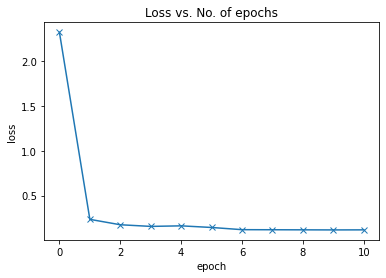

In [76]:
losses = [ x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel ('epoch')
plt.ylabel('loss')
plt.title ( 'Loss vs. No. of epochs');
print (len(history))

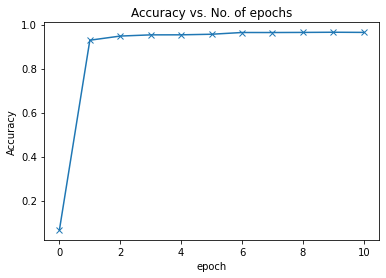

In [80]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel ('epoch')
plt.ylabel ('Accuracy')
plt.title ('Accuracy vs. No. of epochs');